In [ ]:
import shutil
shutil.unpack_archive("Images.zip")

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Load and preprocess the data

# Load the labels from labels.csv

labels_df = pd.read_csv('labels.csv', sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']

# Adjust the image IDs in the dataframe - to 8 digits with padding

labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")

# Use iloc to pick the first 1000 labels

labels_df = labels_df.iloc[:1000]

# Load the corresponding images

images_dir = 'Images/'
images = []
for index, row in labels_df.iterrows():
    img_path = os.path.join(images_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)
    else:
        print(f"Error loading image: {img_path}")

# Converting list of images to numpy array

# images = np.array(images)

# Check if images are loaded

if len(images) == 0:
    print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images)} images loaded successfully.")

1000 images loaded successfully.


In [ ]:
# Analyze the distribution of vehicle types in the limited dataset
vehicle_types = labels_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)

Distribution of vehicle types:
class
car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: count, dtype: int64


In [ ]:
# Address data quality issues arising from the discrepancy between labels and actual image filenames
# Sorting the image filenames
labels_df = labels_df.sort_values('image_id')

In [ ]:
if len(images) > 0:
    processed_images = [cv2.resize(img, (224, 224)) for img in images]
    processed_images = np.array(processed_images)
    print("Images resized successfully.")

Images resized successfully.


In [ ]:
labels = labels_df['class'].to_numpy()
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

# Convert labels to one-hot encoding
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])

In [ ]:
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(processed_images, labels, bounding_boxes, test_size=0.2, random_state=42)

In [ ]:
# Modelling a CNN architecture for object detection with bounding box

def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, activation='softmax',name='bounding_box')(x)

    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
    return model

input_shape = processed_images[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)



model.compile(optimizer='adam',
             loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})



#model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=20, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train},
          epochs=20,
          validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))

In [ ]:
# Evaluate the test results

test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:', test_results)

In [ ]:
# Visulaizing the predicted results

import matplotlib.pyplot as plt

# Choose a few sample images for inference
sample_images = X_test[:8]  # Adjust the number of sample images as needed

# Perform inference on the sample images
predictions = model.predict(sample_images)

# Extract the predicted bounding box coordinates
predicted_bounding_boxes = predictions[1]

# Visualize the sample images with predicted bounding boxes
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                     predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                     predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                     fill=False, edgecolor='r', linewidth=2))

The predictions were not accurate and some of the images did not have bounding boxes as the accuracy is only 61%. For better results using the YOLO (You Only Look Once ) model for training. YOLOv5, are typically pretrained on COCO (Common Objects in Context), which is a large-scale dataset specifically designed for object detection tasks.

In [ ]:
# Cloning YOLO V5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 23.14 MiB/s, done.
Resolving deltas: 100% (11719/11719), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 17.9 MB/s eta 0:00:00


In [ ]:
# Splitting the data to test and train

train_df,test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

In [ ]:
# Checking the number of rows
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 800
Test set size: 200


In [ ]:
# Define directories for images and labels for test and train

base_dir = 'dataset'
train_image_dir = os.path.join(base_dir, 'images/train')
test_image_dir = os.path.join(base_dir, 'images/test')
train_label_dir = os.path.join(base_dir, 'labels/train')
test_label_dir = os.path.join(base_dir, 'labels/test')

# Create directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

In [ ]:
# Helper function to convert bounding box to YOLO format

def convert_to_yolo_format(row, img_width, img_height):
    class_id = row['class']
    x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']

    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return [class_id, x_center, y_center, width, height]

# Function to save image and label files

def save_images_and_labels(df, image_dir, label_dir, img_height, img_width):
    for index, row in df.iterrows():
        image_id = row['image_id']
        # Copy the image to the corresponding folder
        src_image_path = f"/content/Images/{image_id}.jpg"
        dst_image_path = os.path.join(image_dir, f"{image_id}.jpg")

        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dst_image_path)
        else:
            print(f"Image {image_id}.jpg not found!")

        # Generate YOLO format labels and save them
        yolo_format_label = convert_to_yolo_format(row, img_width, img_height)
        label_file_path = os.path.join(label_dir, f"{image_id}.txt")
        with open(label_file_path, 'w') as f:
            f.write(f"{yolo_format_label[0]} {yolo_format_label[1]:.6f} {yolo_format_label[2]:.6f} {yolo_format_label[3]:.6f} {yolo_format_label[4]:.6f}\n")


img_width = 640
img_height = 480

# Save images and labels for the train and test sets
save_images_and_labels(train_df, train_image_dir, train_label_dir, img_height, img_width)
save_images_and_labels(test_df, test_image_dir, test_label_dir, img_height, img_width)

In [ ]:
# Converting the labels to numeric format in labels

# Define your class names in the correct order
class_dict = {
    'pickup_truck': 0,
    'car': 1,
    'articulated_truck': 2,
    'bus': 3,
    'motorized_vehicle': 4,
    'work_van': 5,
    'single_unit_truck': 6,
    'pedestrian': 7,
    'bicycle': 8,
    'non-motorized_vehicle': 9,
    'motorcycle': 10
}

# List of directories to process (train and test)
labels_dirs = ['/content//yolov5/dataset/labels/train', '/content//yolov5/dataset/labels/test']

# Loop over each directory and process the label files
for labels_dir in labels_dirs:
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Replace class names with class IDs
        new_lines = []
        for line in lines:
            parts = line.split()
            class_name = parts[0]
            if class_name in class_dict:
                class_id = class_dict[class_name]
                new_line = f"{class_id} " + " ".join(parts[1:]) + "\n"
                new_lines.append(new_line)

        # Write the updated labels back to the file
        with open(label_path, 'w') as f:
            f.writelines(new_lines)

print("Labels updated for both train and test datasets.")

Labels updated for both train and test datasets.


In [ ]:
# Importing the yaml which contains the path of directories in the readable format
import yaml

data = {

    'train': '/content/yolov5/dataset/images/train',  # Path to training images
    'val': '/content/yolov5/dataset/images/test',     # Path to test images
    'nc': 11,                                  # Number of classes
    'names': ['pickup_truck', 'car', 'articulated_truck', 'bus',
       'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian',
       'bicycle', 'non-motorized_vehicle', 'motorcycle']                   # List of class names
}

with open('dataset.yaml', 'w') as file:
    yaml.dump(data, file)

In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data dataset.yaml --weights yolov5s.pt --cache


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-05 13:22:38.984222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 13:22:39.016413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 13:22:39.026545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplo

In [ ]:
# Inferencing the model based on the saved weights

from yolov5 import detect

# Specify the path to your saved weights
model_weights = 'runs/train/exp2/weights/best.pt'

# Run inference using the saved model weights(Reduced the confidence level considerably to achieve the results)
!python detect.py --weights $model_weights --img 640 --conf 0.001 --source /content/yolov5/dataset/images/test
# Predictions are saved in exp2

detect: weights=['runs/train/exp2/weights/best.pt'], source=/content/yolov5/dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.001, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7039792 parameters, 0 gradients, 15.8 GFLOPs
image 1/135 /content/yolov5/dataset/images/test/00000001.jpg: 448x640 1 pickup_truck, 234 cars, 4 articulated_trucks, 3 buss, 33.7ms
image 2/135 /content/yolov5/dataset/images/test/00000009.jpg: 448x640 273 cars, 4 articulated_trucks, 1 bus, 9.0ms
image 3/135 /content/yolov5/dataset/images/test/

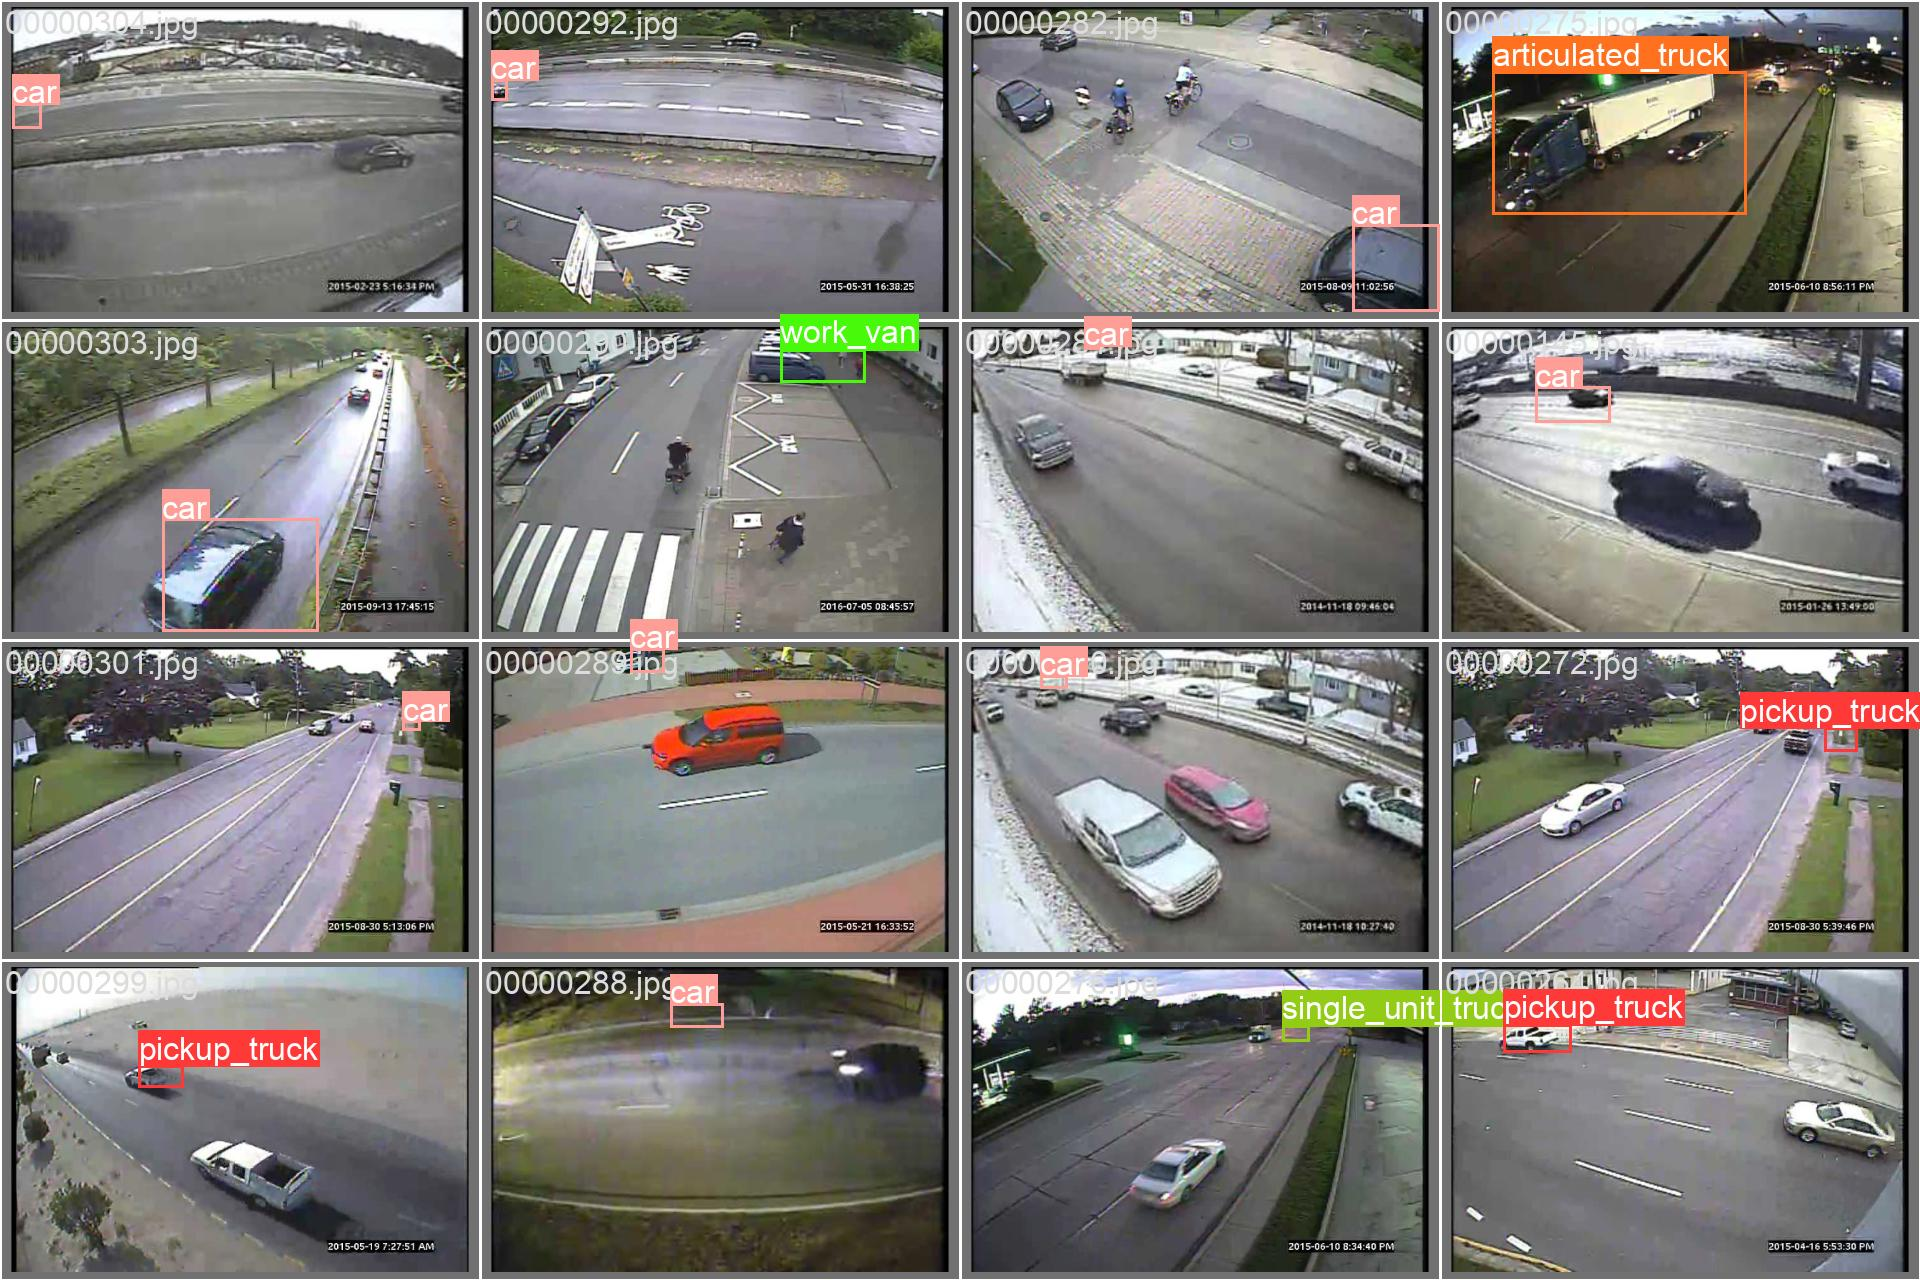

In [ ]:
# Display a few validation images with detection

from IPython.display import Image

Image(filename='/content/yolov5/runs/train/exp/val_batch0_labels.jpg')
Image(filename='/content/yolov5/runs/train/exp/val_batch1_labels.jpg')


In [ ]:
# To display the images in the runs/detect folder

import cv2
from matplotlib import pyplot as plt

# Path to the specific image you want to display
image_path = 'runs/detect/exp6/00000256.jpg'  # Replace with the actual image name

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title(image_path.split('/')[-1])  # Display the image file name
plt.show()